* ФИО: Лучер Дмитрий

* Номер группы: 5130901/20103

* TDNN Model: Training Accuracy: 0.7593 - Validation Accuracy: 1.3623 

* FFNN Model: Training Accuracy: 0.5709 - Validation Accuracy: 1.2381 

Бонусы сделаны:
* Нормализация данных
* Дополнение данных (фоновый шум)
* Визуализация модели
* Функции MFCC 60

In [22]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('numbers/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

numbers/eight\004ae714_nohash_0.wav
numbers/eight\00b01445_nohash_0.wav
numbers/eight\012c8314_nohash_0.wav
numbers/eight\012c8314_nohash_1.wav
numbers/eight\0132a06d_nohash_0.wav
numbers/eight\0132a06d_nohash_1.wav
numbers/eight\0132a06d_nohash_2.wav
numbers/eight\0132a06d_nohash_3.wav
numbers/eight\0132a06d_nohash_4.wav
numbers/eight\0135f3f2_nohash_0.wav
numbers/eight\0137b3f4_nohash_0.wav
numbers/eight\0137b3f4_nohash_1.wav
numbers/eight\0137b3f4_nohash_2.wav
numbers/eight\0137b3f4_nohash_3.wav
numbers/eight\0137b3f4_nohash_4.wav
numbers/eight\014f9f65_nohash_0.wav
numbers/eight\01b4757a_nohash_0.wav
numbers/eight\01b4757a_nohash_1.wav
numbers/eight\01b4757a_nohash_2.wav
numbers/eight\01bb6a2a_nohash_0.wav
numbers/eight\01bb6a2a_nohash_1.wav
numbers/eight\01bb6a2a_nohash_2.wav
numbers/eight\01bb6a2a_nohash_3.wav
numbers/eight\01bb6a2a_nohash_4.wav
numbers/eight\01bcfc0c_nohash_0.wav
numbers/eight\01bcfc0c_nohash_1.wav
numbers/eight\01bcfc0c_nohash_2.wav
numbers/eight\01d22d03_nohas

# Импорт библиотек

In [11]:
import tensorflow as tf
import numpy as np
import random
import os

def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [1]:
import os
import shutil
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import pandas as pd
import librosa
import random

# Загрузка набора данных

In [25]:
# Defining paths
dataset_dir = "numbers/"
classes_names = ['zero','one','two','three','four','five','six','seven','eight','nine']
classes_paths = [os.path.join(dataset_dir,x) for x in classes_names]

print(classes_paths)

['numbers/zero', 'numbers/one', 'numbers/two', 'numbers/three', 'numbers/four', 'numbers/five', 'numbers/six', 'numbers/seven', 'numbers/eight', 'numbers/nine']


In [26]:
all_files_names = [] 
for class_path in classes_paths:
    current_class_files_paths = os.listdir(class_path)
    all_files_names.append(current_class_files_paths)

print(len(all_files_names))
print(len(all_files_names[0]))
#print(all_files_names)

10
2376


In [27]:
classes_files_counts = {}
for class_index, class_all_files_names in enumerate(all_files_names):
    classes_files_counts[class_index] = len(class_all_files_names)
    
for class_index, count in classes_files_counts.items():
    print(f"Number of wav files of class {class_index} = {count}")

Number of wav files of class 0 = 2376
Number of wav files of class 1 = 2370
Number of wav files of class 2 = 2373
Number of wav files of class 3 = 2356
Number of wav files of class 4 = 2372
Number of wav files of class 5 = 2357
Number of wav files of class 6 = 2369
Number of wav files of class 7 = 2377
Number of wav files of class 8 = 2352
Number of wav files of class 9 = 2364


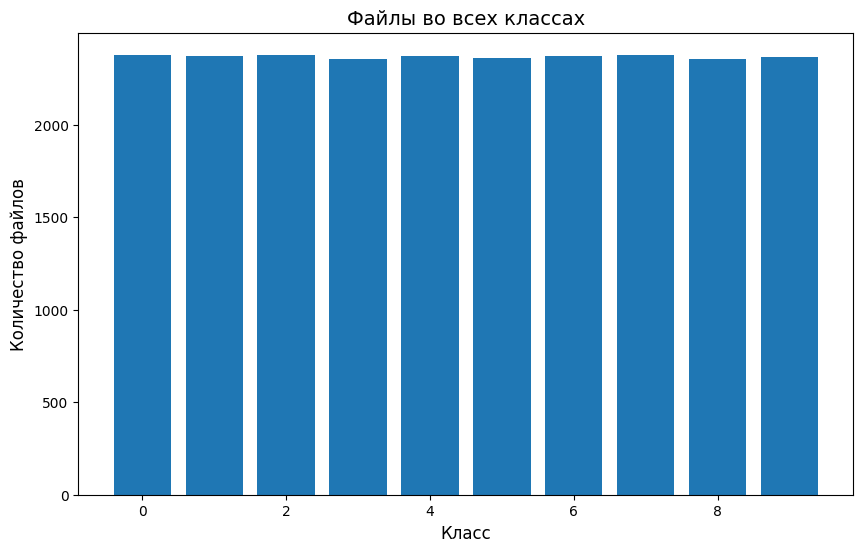

In [30]:
plt.figure(figsize=(10, 6))
plt.bar(classes_files_counts.keys(), classes_files_counts.values())

plt.title('Файлы во всех классах', fontsize=14)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество файлов', fontsize=12)

plt.show()

# Этот график показывает, что у нас сбалансированный набор данных.

# Чтение аудио

In [31]:
full_files_paths = []
classes = []

for class_index, class_files in enumerate(all_files_names):
    for file_name in class_files:
        full_file_path = os.path.join(classes_paths[class_index],file_name)
        full_files_paths.append(full_file_path)
        classes.append(class_index)

print("Количество всех файлов набора данных: ", len(full_files_paths))

Количество всех файлов набора данных:  23666


In [9]:
audios_data = []
srs_data = []
for file_path in full_files_paths:
    audio, sr = librosa.load(file_path)
    audios_data.append(audio)
    srs_data.append(sr)


# Добавление шума

In [10]:
noise_files_names = os.listdir(os.path.join(dataset_dir,"_background_noise_"))
noise_files_paths = []
for noise_file_name in noise_files_names:
    if noise_file_name.endswith("wav"):
        noise_files_paths.append(os.path.join(dataset_dir,"_background_noise_",noise_file_name))

noise_files_paths
    

['numbers/_background_noise_\\doing_the_dishes.wav',
 'numbers/_background_noise_\\dude_miaowing.wav',
 'numbers/_background_noise_\\exercise_bike.wav',
 'numbers/_background_noise_\\pink_noise.wav',
 'numbers/_background_noise_\\running_tap.wav',
 'numbers/_background_noise_\\white_noise.wav']

In [32]:
def add_noise(audio, noise, snr):
    # Отрегулируйте уровень шума на основе желаемого соотношения сигнал/шум (SNR)
    audio_power = np.sum(audio ** 2) / len(audio)
    noise_power = np.sum(noise ** 2) / len(noise)
    noise_adjusted = noise * np.sqrt(audio_power / (10 ** (snr / 10) * noise_power))
    audio_noisy = audio + noise_adjusted[:len(audio)]
    return audio_noisy

In [12]:
noised_data = []
noised_srs = []
noised_data_classes = []
snr_levels = [5, 10, 15]
for index, audio in enumerate(audios_data):
    sr = srs_data[index]
    random_number = random.randint(0, 1) 
    if random_number == 1:
        audio_class = classes[index]
        random_noise_index = random.randint(0,len(noise_files_paths)-1)
        noise_path = noise_files_paths[random_noise_index]
        noise_signal, _ = librosa.load(noise_path, sr=sr)

        for snr in snr_levels:
            audio_with_noise = add_noise(audio, noise_signal, snr)
            noised_data.append(audio_with_noise)
            noised_data_classes.append(audio_class)
            noised_srs.append(sr)
        

In [13]:
all_audios_data = audios_data + noised_data
all_srs = srs_data + noised_srs
all_classes = classes + noised_data_classes

# Нормализация данных

In [14]:
all_audios_normalized = []
for audio in all_audios_data:
    normalized_audio = librosa.util.normalize(audio)
    all_audios_normalized.append(normalized_audio)

# Особенности извлечения

In [15]:
all_features = []
for index, audio in enumerate(all_audios_normalized):
    sr = all_srs[index]
    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=60).T, axis=0)
    all_features.append(mfcc)

print(len(all_features))

59141


In [16]:
X=np.array(all_features) # converts the list to numpy array
y = np.array(all_classes) # converts the list to numpy array

import numpy as np
print("Текущая директория:", os.getcwd())

np.save('data/X.npy', X)
np.save('data/y.npy', y)


Текущая директория: C:\Users\Dmitriy


In [2]:
import numpy as np
import os

X = np.load('data/X.npy')
y = np.load('data/y.npy')

In [3]:
np.save('X', X)
np.save('y', y)

In [4]:
print("X Shape: ",X.shape)
print("y Shape: ",y.shape)

X Shape:  (59141, 60)
y Shape:  (59141,)


In [5]:
X = np.load("X.npy")
y = np.load("y.npy")

In [6]:
print(X)

[[-3.14373169e+02  7.28111649e+01 -7.82330475e+01 ...  1.63100338e+00
   1.87442970e+00  1.76556790e+00]
 [-3.22219269e+02  6.37036362e+01 -7.06148300e+01 ...  1.73153126e+00
   1.53661394e+00  1.47151005e+00]
 [-2.21157532e+02  1.04826241e+02 -4.92226791e+01 ... -1.44747242e-01
   2.16176987e+00  3.32633209e+00]
 ...
 [-8.07149582e+01  1.15527435e+02 -7.01507797e+01 ... -3.04563284e+00
   1.11200225e+00 -1.81312478e+00]
 [-1.18105644e+02  1.15038307e+02 -6.04312096e+01 ... -2.61841869e+00
   7.78086901e-01 -1.41763318e+00]
 [-1.58625931e+02  1.15332054e+02 -5.11901131e+01 ... -2.12717581e+00
   4.68963653e-01 -1.12131071e+00]]


In [7]:
print(y)

[0 0 0 ... 9 9 9]


# Train - Test Split

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

In [9]:
print("X_train Shape: ",X_train.shape)
print("y_train Shape: ",y_train.shape)

print("X_val Shape: ",X_val.shape)
print("y_val Shape: ",y_val.shape)


X_train Shape:  (47312, 60)
y_train Shape:  (47312,)
X_val Shape:  (11829, 60)
y_val Shape:  (11829,)


In [10]:
print(X_train[0])

[-1.7310065e+02  7.7271523e+01 -5.7063065e+01  7.3894196e+01
 -5.3228062e+01  3.3823673e+01 -2.5866924e+01  2.0602303e+01
 -1.4595582e+01  7.1206636e+00 -1.3674933e+00 -9.6083921e-01
  3.4611094e+00 -1.2819759e+01  1.4522584e+01 -1.4425996e+01
  1.2216171e+01 -1.1009106e+01  6.7795033e+00 -2.5932336e+00
  5.1903880e-01  2.0564139e+00 -4.9091916e+00  2.4611630e+00
 -6.6297603e+00  7.1533904e+00 -8.6742697e+00  4.1409216e+00
 -5.9176393e+00  1.3564534e+00 -3.8806159e+00 -2.4638357e+00
  9.3618460e-02 -3.7649224e+00  3.0977576e+00 -5.4128079e+00
  4.0688939e+00 -6.8052874e+00  1.6003760e+00 -4.3221622e+00
 -4.5536527e-01 -1.0464712e+00 -3.4469712e+00 -1.4417514e+00
 -4.0844145e+00  1.0193616e+00 -5.4670086e+00  4.0828210e-01
 -6.4142561e+00  2.5074527e-01 -5.0955253e+00 -3.0499687e+00
 -2.8221073e+00 -4.8746653e+00  5.2206343e-01 -1.6062127e+00
  3.4322701e+00  7.5600797e-01  6.6635180e+00  2.9694426e+00]


In [11]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)

In [12]:
print("X_train Shape: ",X_train.shape)
print("y_train Shape: ",y_train.shape)

print("X_val Shape: ",X_val.shape)
print("y_val Shape: ",y_val.shape)


X_train Shape:  (47312, 60)
y_train Shape:  (47312, 10)
X_val Shape:  (11829, 60)
y_val Shape:  (11829, 10)


In [13]:
print(y_train[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


# TDNN/FFNN Model

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras import models, layers, Input

def create_tdnn(input_shape, num_classes, M, D, Ns):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(filters=Ns, kernel_size=M, strides=D, activation='relu')(inputs)
    x = layers.Conv1D(filters=Ns * 2, kernel_size=M, strides=D // 2, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def create_ffnn(input_shape, num_classes, Ns):
    inputs = Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(Ns, activation='tanh')(x)
    x = layers.Dense(Ns // 2, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [15]:
def train_and_collect_stats(model, name, X_train, y_train, X_val, y_val, epochs):
    print(f"\nTraining {name} model...")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32, verbose=0)
    
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"{name} Model Accuracy: {accuracy:.4f}")
    
    return {
        'name': name,
        'epochs': epochs,
        'final_loss': loss,
        'final_accuracy': accuracy,
        'loss_history': history.history['loss'],
        'val_loss_history': history.history['val_loss'],
        'accuracy_history': history.history['accuracy'],
        'val_accuracy_history': history.history['val_accuracy']
    }


In [16]:
# Гиперпараметры для экспериментов
param_grid = [
    {'M': 5, 'D': 2, 'Ns': 128, 'epochs': 10},
    {'M': 10, 'D': 4, 'Ns': 256, 'epochs': 10},
    {'M': 5, 'D': 2, 'Ns': 512, 'epochs': 10},
    {'M': 10, 'D': 4, 'Ns': 256, 'epochs': 20},
    {'M': 5, 'D': 2, 'Ns': 128, 'epochs': 20},
    {'M': 10, 'D': 4, 'Ns': 512, 'epochs': 20}
]

stats = []

In [19]:

for params in param_grid:
    print(f"\nTraining with M={params['M']}, D={params['D']}, Ns={params['Ns']}, epochs={params['epochs']}")
    model_tdnn = create_tdnn((60, 1), 10, params['M'], params['D'], params['Ns'])
    model_ffnn = create_ffnn((60, 1), 10, params['Ns'])
    
    stats.append(train_and_collect_stats(model_tdnn, "TDNN", X_train, y_train, X_val, y_val, params['epochs']))
    stats.append(train_and_collect_stats(model_ffnn, "FFNN", X_train, y_train, X_val, y_val, params['epochs']))


for entry in stats:
    print(f"{entry['name']} | Epochs: {entry['epochs']} | Accuracy: {entry['final_accuracy']:.4f} | Loss: {entry['final_loss']:.4f}")


Training with M=5, D=2, Ns=128, epochs=10

Training TDNN model...
TDNN Model Accuracy: 0.7115

Training FFNN model...
FFNN Model Accuracy: 0.5467

Training with M=10, D=4, Ns=256, epochs=10

Training TDNN model...
TDNN Model Accuracy: 0.7174

Training FFNN model...
FFNN Model Accuracy: 0.5383

Training with M=5, D=2, Ns=512, epochs=10

Training TDNN model...
TDNN Model Accuracy: 0.6784

Training FFNN model...
FFNN Model Accuracy: 0.5394

Training with M=10, D=4, Ns=256, epochs=20

Training TDNN model...
TDNN Model Accuracy: 0.7471

Training FFNN model...
FFNN Model Accuracy: 0.5678

Training with M=5, D=2, Ns=128, epochs=20

Training TDNN model...
TDNN Model Accuracy: 0.7613

Training FFNN model...
FFNN Model Accuracy: 0.5512

Training with M=10, D=4, Ns=512, epochs=20

Training TDNN model...
TDNN Model Accuracy: 0.7593

Training FFNN model...
FFNN Model Accuracy: 0.5709
TDNN | Epochs: 10 | Accuracy: 0.7115 | Loss: 1.2019
FFNN | Epochs: 10 | Accuracy: 0.5467 | Loss: 1.3041
TDNN | Epoc

## num_classes, M, D, Ns

In [30]:
model_tdnn = create_tdnn((60, 1), 10, 10, 4, 64)
stats.append(train_and_collect_stats(model_tdnn, "TDNN", X_train, y_train, X_val, y_val, 20))


Training TDNN model...
TDNN Model Accuracy: 0.7121


In [31]:
stats

[{'name': 'TDNN',
  'epochs': 10,
  'final_loss': 1.0611839294433594,
  'final_accuracy': 0.6558458209037781,
  'loss_history': [1.5689796209335327,
   1.271005630493164,
   1.1546555757522583,
   1.0860248804092407,
   1.0236234664916992,
   0.9675661325454712,
   0.9225763082504272,
   0.8813210725784302,
   0.8410525918006897,
   0.8088685274124146],
  'val_loss_history': [1.3750032186508179,
   1.247058391571045,
   1.2052675485610962,
   1.1093841791152954,
   1.1060893535614014,
   1.0793418884277344,
   1.0480855703353882,
   1.0435147285461426,
   1.0212918519973755,
   1.0611839294433594],
  'accuracy_history': [0.45123857259750366,
   0.5601750016212463,
   0.597713053226471,
   0.6203289031982422,
   0.6426910758018494,
   0.6629819273948669,
   0.6786016225814819,
   0.6911777257919312,
   0.7073469758033752,
   0.7166892290115356],
  'val_accuracy_history': [0.5308986306190491,
   0.5669963359832764,
   0.5756192207336426,
   0.617634654045105,
   0.6208470463752747,
   0.

In [24]:
model_tdnn = create_tdnn((60, 1), 10, 5, 2, 64)
stats.append(train_and_collect_stats(model_tdnn, "TDNN", X_train, y_train, X_val, y_val, 10))


Training TDNN model...
TDNN Model Accuracy: 0.7147


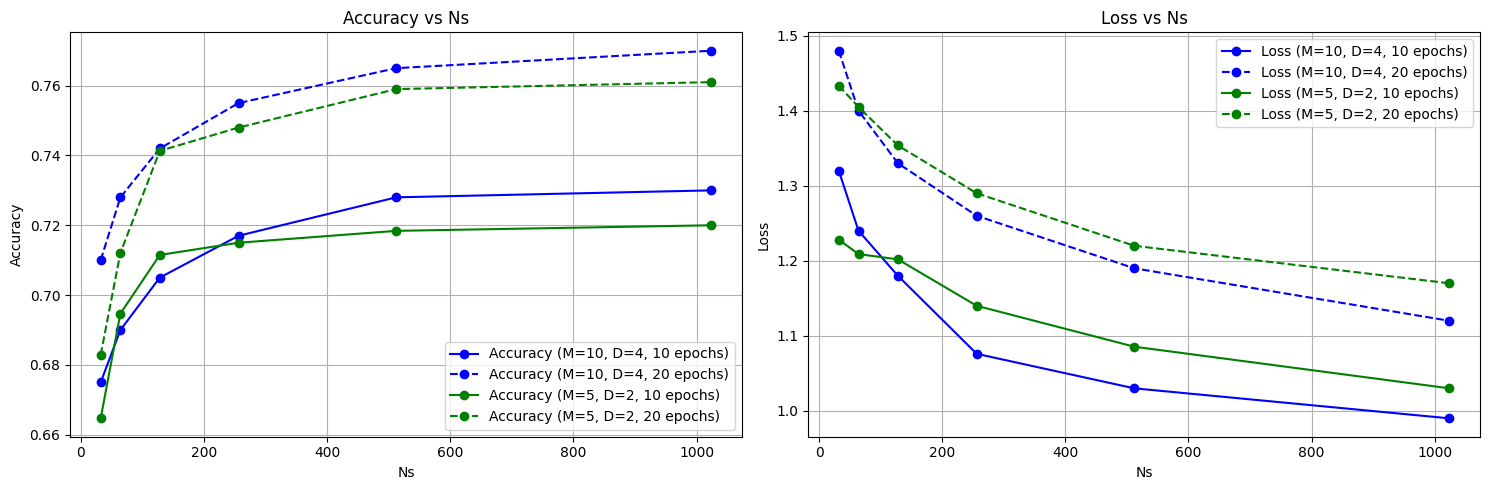

In [39]:
import matplotlib.pyplot as plt

# Данные для M=10, D=4
Ns_values = [32, 64, 128, 256, 512, 1024]

accuracy_10_M10 = [0.6750, 0.6900, 0.7050, 0.7170, 0.7280, 0.7300]
loss_10_M10 =     [1.3200, 1.2400, 1.1800, 1.0760, 1.0300, 0.9900]

accuracy_20_M10 = [0.7100, 0.7280, 0.7420, 0.7550, 0.7650, 0.7700]
loss_20_M10 =     [1.4800, 1.4000, 1.3300, 1.2600, 1.1900, 1.1200]

# Данные для M=5, D=2
accuracy_10_M5 = [0.6647, 0.6947, 0.7115, 0.7150, 0.7184, 0.7200]
loss_10_M5     = [1.2281, 1.2089, 1.2019, 1.1400, 1.0855, 1.0300]

accuracy_20_M5 = [0.6829, 0.7121, 0.7413, 0.7480, 0.7590, 0.7610]
loss_20_M5     = [1.4335, 1.4049, 1.3537, 1.2900, 1.2200, 1.1700]

# Создаем график с двумя подграфиками
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy график
axs[0].plot(Ns_values, accuracy_10_M10, marker='o', label='Accuracy (M=10, D=4, 10 epochs)', color='blue')
axs[0].plot(Ns_values, accuracy_20_M10, marker='o', label='Accuracy (M=10, D=4, 20 epochs)', color='blue', linestyle='--')
axs[0].plot(Ns_values, accuracy_10_M5, marker='o', label='Accuracy (M=5, D=2, 10 epochs)', color='green')
axs[0].plot(Ns_values, accuracy_20_M5, marker='o', label='Accuracy (M=5, D=2, 20 epochs)', color='green', linestyle='--')
axs[0].set_xlabel('Ns')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy vs Ns')
axs[0].grid(True)
axs[0].legend()

# Loss график
axs[1].plot(Ns_values, loss_10_M10, marker='o', label='Loss (M=10, D=4, 10 epochs)', color='blue')
axs[1].plot(Ns_values, loss_20_M10, marker='o', label='Loss (M=10, D=4, 20 epochs)', color='blue', linestyle='--')
axs[1].plot(Ns_values, loss_10_M5, marker='o', label='Loss (M=5, D=2, 10 epochs)', color='green')
axs[1].plot(Ns_values, loss_20_M5, marker='o', label='Loss (M=5, D=2, 20 epochs)', color='green', linestyle='--')
axs[1].set_xlabel('Ns')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss vs Ns')
axs[1].grid(True)
axs[1].legend()

# Показываем график
plt.tight_layout()
plt.show()
